In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato_Datasets",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [16]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[9 7 6 7 1 6 5 7 2 0 2 2 5 2 0 7 7 9 4 6 4 5 7 5 7 3 0 3 7 7 1 1]


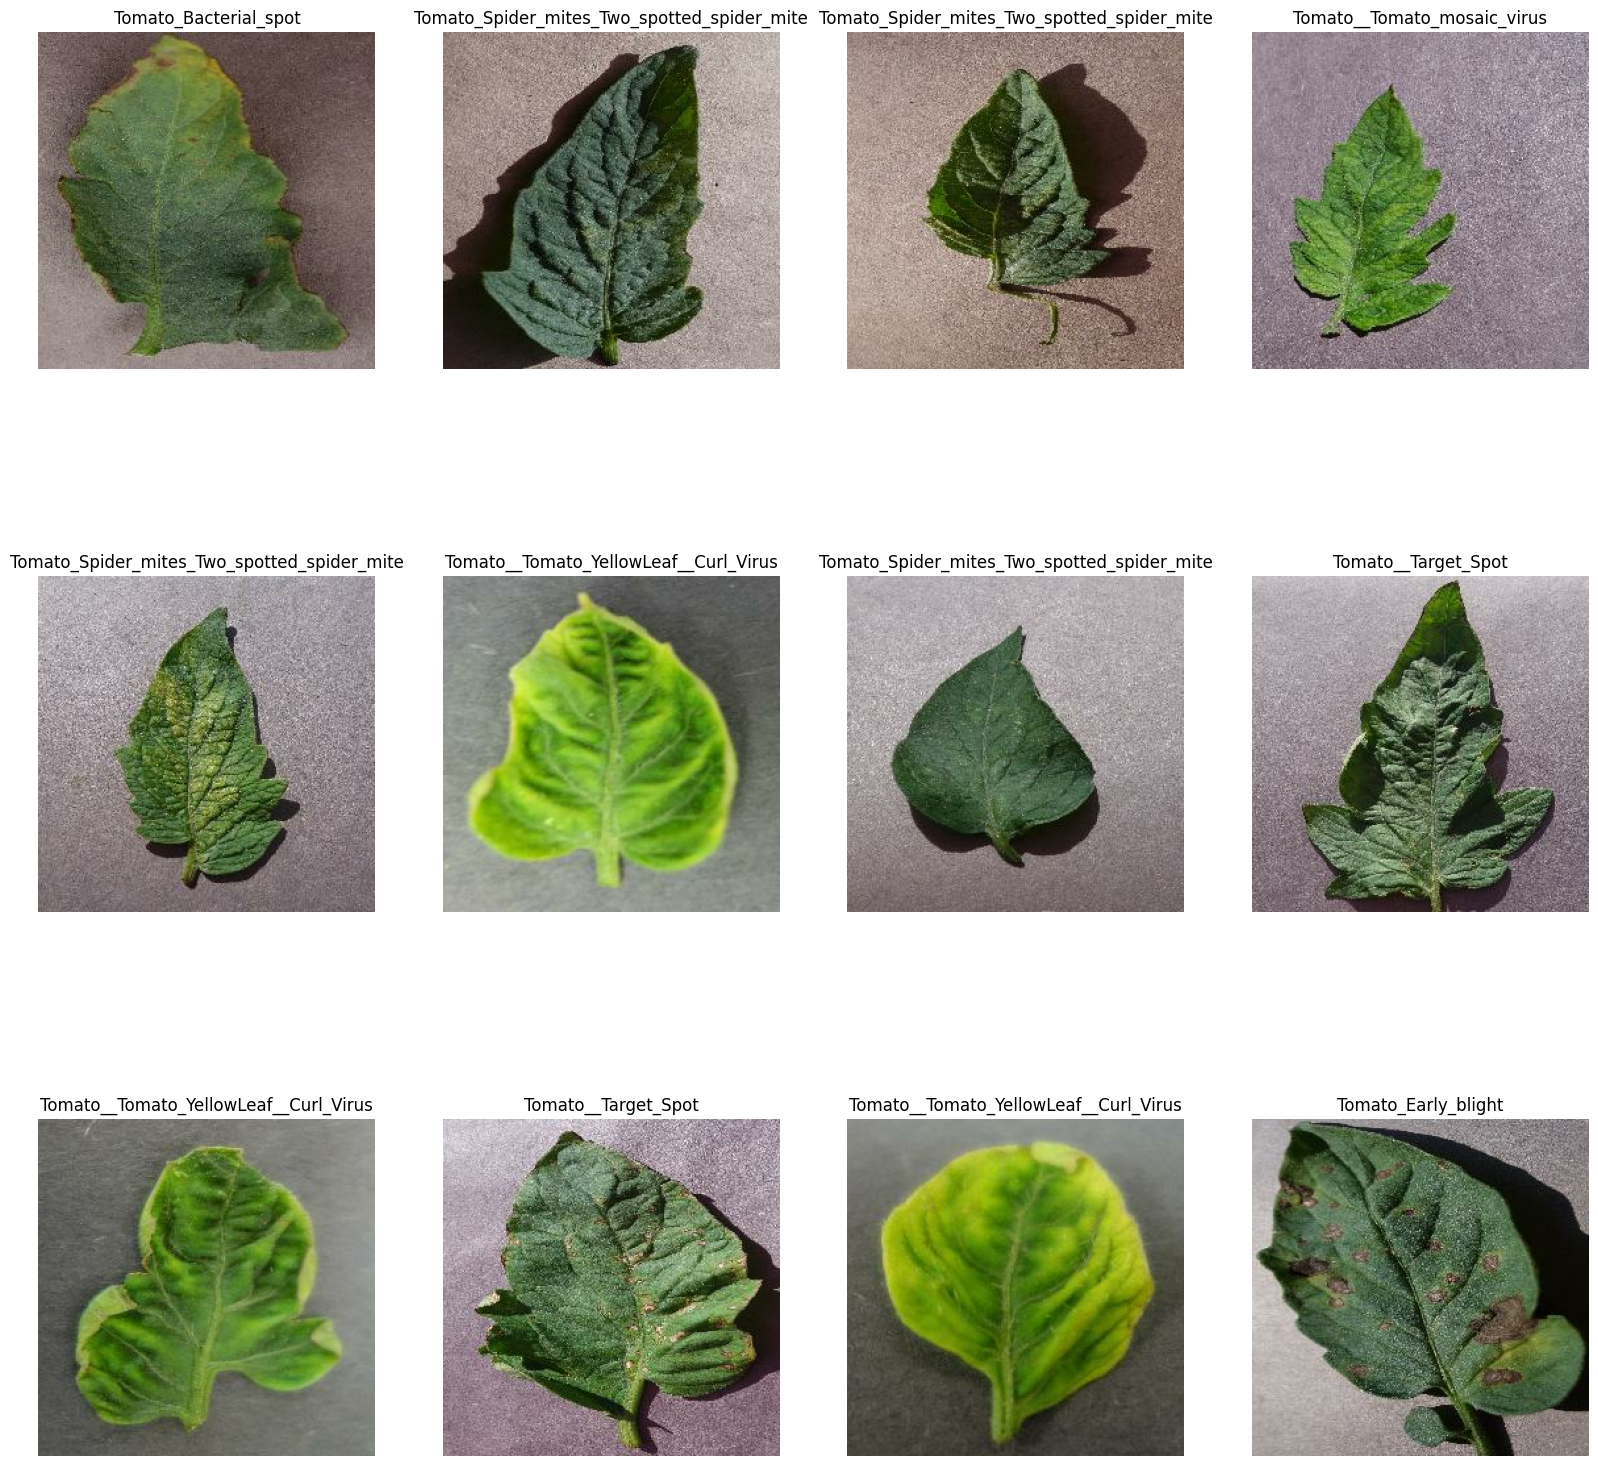

In [25]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
#         print(len(image_batch))
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [27]:
len(dataset)

501

In [28]:
train_size = 0.8
len(dataset)*train_size

400.8

In [29]:
train_ds = dataset.take(400)
len(train_ds)

400

In [30]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [33]:
val_size=0.1
len(dataset)*val_size

50.1

In [34]:
val_ds = test_ds.take(50)
len(val_ds)

50

In [35]:
test_ds = test_ds.skip(50)
len(test_ds)

51

In [36]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [40]:
len(test_ds)

51

In [41]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [43]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [44]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
len(class_names)

10

In [50]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [51]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [52]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [53]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
400/400 [==============================] - 755s 2s/step - loss: 1.5777 - accuracy: 0.4483 - val_loss: 1.1054 - val_accuracy: 0.6019
Epoch 2/50
400/400 [==============================] - 732s 2s/step - loss: 0.9677 - accuracy: 0.6613 - val_loss: 1.0669 - val_accuracy: 0.6169
Epoch 3/50
400/400 [==============================] - 709s 2s/step - loss: 0.6848 - accuracy: 0.7569 - val_loss: 1.2607 - val_accuracy: 0.6450
Epoch 4/50
400/400 [==============================] - 701s 2s/step - loss: 0.5668 - accuracy: 0.8011 - val_loss: 0.5756 - val_accuracy: 0.8006
Epoch 5/50
400/400 [==============================] - 717s 2s/step - loss: 0.4601 - accuracy: 0.8351 - val_loss: 0.7838 - val_accuracy: 0.7356
Epoch 6/50
400/400 [==============================] - 706s 2s/step - loss: 0.3980 - accuracy: 0.8574 - val_loss: 0.4577 - val_accuracy: 0.8338
Epoch 7/50
400/400 [==============================] - 723s 2s/step - loss: 0.3607 - accuracy: 0.8719 - val_loss: 0.3515 - val_accuracy: 0.8856

In [54]:
scores = model.evaluate(test_ds)


NotFoundError: Graph execution error:

NewRandomAccessFile failed to Create/Open: Tomato Datasets\Tomato_Septoria_leaf_spot\e8aed11f-46ec-4c63-954d-c1320d99040d___Matt.S_CG 6760.JPG : The system cannot find the path specified.
; No such process
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]] [Op:__inference_test_function_7804]